In [1]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Pest_data.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [2]:
import os

# Imports
import numpy as np
import pandas as pd

# Visualization (optional for training monitoring)
import matplotlib.pyplot as plt

# Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50

# Image loading/preprocessing (optional, might need adjustments)
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import models

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
# Inline plotting (optional)
%matplotlib inline



In [3]:
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)
grid_shape = (1, image_size, image_size, 3)

batch_size = 32

train_dir = "/content/Pest_data/Train"
test_dir = "/content/Pest_data/Test"
valid_dir = "/content/Pest_data/Valid"

In [4]:
num_classes = len(os.listdir(train_dir))

In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Data generators
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_data = test_datagen.flow_from_directory(
    valid_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 3852 images belonging to 12 classes.
Found 1098 images belonging to 12 classes.
Found 558 images belonging to 12 classes.


In [6]:
from tensorflow.keras.models import Sequential

In [10]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)

# Freeze pre-trained layers (can be fine-tuned later)
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  # Example dense layer with more units
x = Dropout(0.5)(x)  # Regularization
x = Dense(512, activation='relu')(x)  # Example dense layer with more units
x = Dropout(0.3)(x)  # Regularization
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Adjust learning rate if needed
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
total_train_images = 3852  # Count total training images
steps_per_epoch = int(total_train_images // batch_size)

In [ ]:
num_epochs = 30
history = model.fit(
    train_data,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_data,
    validation_steps=int(len(valid_data.filenames) // batch_size),
    callbacks=[early_stopping]
)

Epoch 1/30
120/120 [==============================] - 64s 530ms/step - loss: 1.2578 - accuracy: 0.6749 - val_loss: 0.5810 - val_accuracy: 0.8355
Epoch 2/30
120/120 [==============================] - 62s 515ms/step - loss: 1.0505 - accuracy: 0.7102 - val_loss: 0.5347 - val_accuracy: 0.8502
Epoch 3/30
120/120 [==============================] - 58s 481ms/step - loss: 0.9074 - accuracy: 0.7317 - val_loss: 0.5029 - val_accuracy: 0.8658
Epoch 4/30
120/120 [==============================] - 57s 477ms/step - loss: 0.8380 - accuracy: 0.7581 - val_loss: 0.4716 - val_accuracy: 0.8824
Epoch 5/30
120/120 [==============================] - 58s 483ms/step - loss: 0.7444 - accuracy: 0.7848 - val_loss: 0.5324 - val_accuracy: 0.8640
Epoch 6/30
120/120 [==============================] - 59s 490ms/step - loss: 0.6941 - accuracy: 0.7950 - val_loss: 0.4819 - val_accuracy: 0.8741
Epoch 7/30
120/120 [==============================] - 62s 514ms/step - loss: 0.6714 - accuracy: 0.8026 - val_loss: 0.4843 - val_ac

In [ ]:
val_loss, val_acc = model.evaluate(valid_data)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

35/35 [==============================] - 4s 120ms/step - loss: 0.5746 - accuracy: 0.8661
Validation Loss: 0.5746, Validation Accuracy: 0.8661


In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

18/18 [==============================] - 3s 186ms/step - loss: 0.6877 - accuracy: 0.8280
Test Loss: 0.6877, Test Accuracy: 0.8280


In [ ]:
class_mapping = train_data.class_indices

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions for the test set
y_pred = model.predict(test_data, steps=len(test_data))
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
true_classes = test_data.classes

18/18 [==============================] - 4s 127ms/step


In [ ]:
print(classification_report(true_classes, y_pred_classes, target_names=class_mapping.keys()))

              precision    recall  f1-score   support

        ants       0.92      0.96      0.94        49
        bees       0.89      0.82      0.85        50
      beetle       0.74      0.64      0.68        44
catterpillar       0.73      0.73      0.73        64
  earthworms       0.77      0.55      0.64        31
      earwig       0.75      0.83      0.78        46
 grasshopper       0.71      0.74      0.73        47
        moth       0.96      0.96      0.96        49
        slug       0.71      0.79      0.75        38
       snail       0.96      0.98      0.97        49
        wasp       0.95      0.87      0.91        46
      weevil       0.81      0.98      0.89        45

    accuracy                           0.83       558
   macro avg       0.83      0.82      0.82       558
weighted avg       0.83      0.83      0.83       558



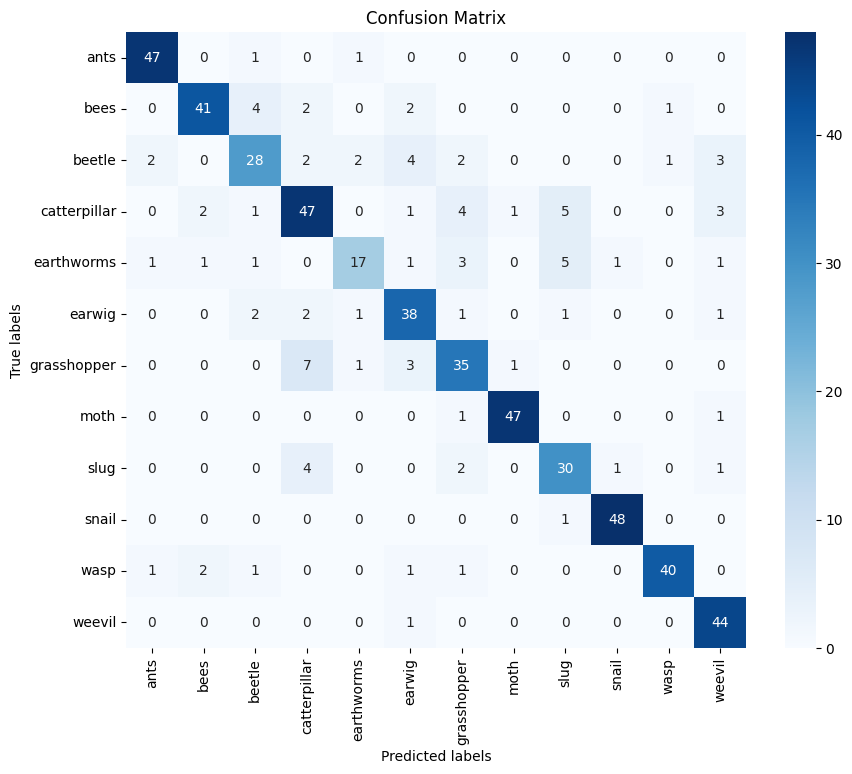

In [ ]:
import seaborn as sns

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

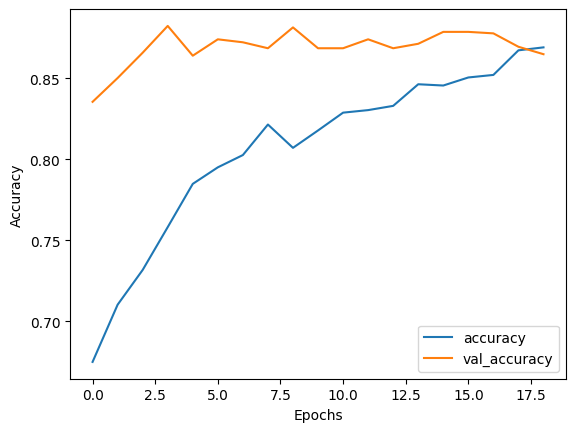

In [ ]:
hist = history.history

# Plot accuracy and validation accuracy
plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["val_accuracy"], label="val_accuracy")

# Add the labels and legend
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.show()

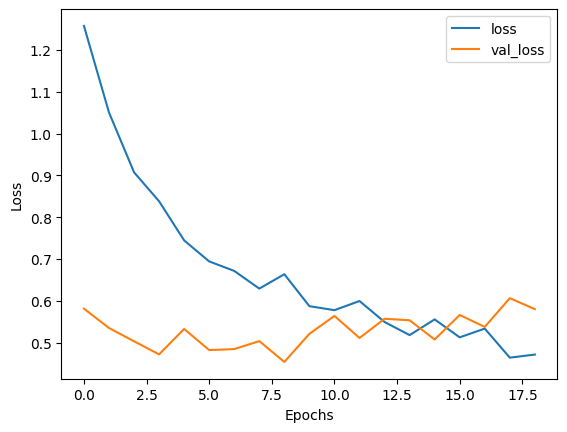

In [ ]:
plt.plot(hist["loss"], label="loss")
plt.plot(hist["val_loss"], label="val_loss")

# Add the labels and legend
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.show()

In [ ]:
model.save("/content/drive/MyDrive/pest_classification.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import json

from IPython.display import FileLink

# Link the files
FileLink("./content/drive/MyDrive/pest_classification.h5")

/content/content/drive/MyDrive/pest_classification.h5